<a href="https://colab.research.google.com/github/pwolscho/unet/blob/master/u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


![U-Net Demonstration](https://drive.google.com/uc?id=1-kEr1EjJgpSjGCV1oFfYw_A2cnu5cNVI)

#Über dieses Notebook

U-Net ist die bekannteste Architektur im Bereich der Semantischen Segmentierung (Anwendung: Segmentierung in Bildern). Im Rahmen des Kurses Seminat-Deep-Learning der Hochschule Offenburg zeigt dieses Notebook eine mögliche Implementierung von U-Net und demonstriert dessen Anwendung anhand eines Beispiel-Datensatzes.

##Informationen zum Datensatz

Mehrere Gebiete der Erde mit großen Öl- und Gasansammlungen haben auch riesige Salzlagerstätten unter der Oberfläche, d.h. dort wo Salz ist, wird vermutlich auch das wertvolle Öl zu finden sein.

Professionelle seismische Messungen zum Auffinden der Salzlagerstätten erfordert immer noch eine fachkundige menschliche Interpretation der daraus resultierenden Bilddaten. Dies führt zu sehr subjektiven, sehr variablen Ergebnissen. Das führt zu potenziell gefährlichen Situationen für Bohrer von Öl- und Gasunternehmen.

Um sehr präzise seismischen Bilder zu erstellen, hofft TGS-NOPEC Geophysical Systems (das weltweit führende Unternehmen für geophysikalische Dienste), dass die Online-Community von Kaggle in der Lage sein wird, einen Algorithmus zu entwickeln, der automatisch und genau erkennt, ob und Salz unter der Erdoberfläche zu finden ist oder nicht.

Dazu wurde im Jahr 2018 eine Wettbewerb von Kaggle durchgeführt.

Auf den diesem Notebook verwendete Datensatz kann nach wie vor unter https://www.kaggle.com/c/tgs-salt-identification-challenge/data  zugegriffen werden.

Die Daten sind eine Reihe von seismischen Bildern von zufällig ausgewählten Orten der Erde. Die Bilder sind 101 x 101 Pixel groß und jedes Pixel wird entweder als Salz oder als Sediment klassifiziert. Zusätzlich zu den seismischen Bildern wird für jedes Bild die Tiefe der aufgenommenen Position angegeben.

##Gliederung des Notebooks

Die durchgeführten Schritte gliedern sich chronologisch wie folgt:

- Vorbereitende Maßnahmen
  - Installation und Einbindung benötigter Pakete
  - Download des Datensatzes
  - Einfache Betrachtung des Datensatzes
  - Identifikation möglicher Zusatzinformationen und detailierte Betrachtung des Datensatzes
- Definition des U-Net-Modells
- Training des U-Net-Modells
- Evaluierung des U-Net-Modells

#I. Vorbereitende Maßnahmen

##Einbinden aller benötigter Bibliotheken

In [1]:
#Installation ist vermutlich überflüssig, da schon in VM vorhanden
!pip install imageio #Lesen und Schreiben von Bilddaten
!pip install torch #Deep-Learning Bibliothek
!pip install kaggle #Zugriff auf den Datensatz von Kaggle
!pip install ipywidgets #Besondere grafische Schnittstellen

In [2]:
#libraries for chapter I. Vorbereitende Maßnahmen
import os
import imageio
import torch
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils import data
from google.colab import drive
from google.colab import files
from zipfile import ZipFile

#libraries for chapter II. Training des Netzwerks
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from __future__ import absolute_import, division, print_function, unicode_literals
from keras import backend as K

import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize

from sklearn.model_selection import train_test_split


Using TensorFlow backend.


##Setzen globaler Einstellungen

In [0]:
#Anzeigen von Plots direkt unter der Plot-generierenden Zelle
%matplotlib inline

##Bereitstellung des Datensatzes

###Zugriff auf die Kaggle-API vorbereiten

Um auf den Datensatz von Kaggle zugreifen zu können, wird die Kaggle-API (https://www.kaggle.com/docs/api) und einen persönlichen API-Token benötigt. Der API-Token kann im persönlichen Account von Kaggle generiert werden. Um den manuellen Upload (files.upload()) zu umgehen wird der Inhalt des Tokens hartkodiert.

In [0]:
kaggle_json = '{"username":"philipwolschon","key":"715ad801ca6728d6730b7c276db32c6f"}'

Zunächst wird die leere Datei kaggle.json angelegt und mit dem Inhalt des kaggle_json-Objekts (API-Token) befüllt.

In [0]:
with open('kaggle.json', 'w') as file:
  json.dump(kaggle_json, file, ensure_ascii=False)

In [0]:
with open('kaggle.json', 'w') as file:
  file.write(kaggle_json)

Außerdem erwartet die Kaggle-API, dass der API-Token in ~/.kaggle/ (/root/.kaggle/) zu finden ist. Daher wird das Verzeichnis "kaggle" erstellt und der API-Token dort hin verschoben.

In [0]:
!mkdir -p ~/.kaggle #Den Ordner anlegen
!mv kaggle.json ~/.kaggle/ #Den API-Token verschieben

Liefert folgende Funktion True zurück wurde die erforderliche Datei im korrekten Verzeichnis der VM erstellt (eine manuelle Prüfung ist nicht möglich, da der Zugriff auf das root-Verzeichnis der VM eingeschränkt ist).

In [8]:
os.path.isfile("/root/.kaggle/kaggle.json")

True

Um Warnungen beim Starten von Kaggle-Tools zu vermeiden werdem dem Besitzer der Datei Lese- und Schreibrechte gewährt.

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

###Download und Entpacken des Datensatzes

Mit Hilfe der Kaggle-API kann nun das Datenset heruntergeladen werden.

In [10]:
!kaggle competitions download -c tgs-salt-identification-challenge -p /content/salt_data 

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 39.7MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 59.2MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 61.4MB/s]
 96% 156M/163M [00:02<00:00, 67.6MB/s]
100% 163M/163M [00:02<00:00, 61.7MB/s]
 79% 30.0M/37.9M [00:00<00:00, 23.0MB/s]
100% 37.9M/37.9M [00:00<00:00, 52.0MB/s]


Die Trainigs- und Testdaten sind komprimiert und müssen zunächst entpackt werden.

In [0]:
#Entpacken der Testdaten
with ZipFile('/content/salt_data/test.zip', 'r') as zipObj:
   zipObj.extractall('/content/salt_data/test')
#Entpacken der Trainingsdaten
with ZipFile('/content/salt_data/train.zip', 'r') as zipObj:
   zipObj.extractall('/content/salt_data/train')

##Sichtung des Datensatzes

Der Datensatz enthält 18000 Testbilder und 4000 Trainingsbilder d.h in Summe sind 22000 Bilder verfügbar.

In [13]:
print("Number of test images: " + str(len(os.listdir("/content/salt_data/test/images"))))
print("Number of train images: " + str(len(os.listdir("/content/salt_data/train/images"))))

Number of test images: 18000
Number of train images: 4000


Der Datensatz beinhaltet neben den Trainigs- und Testbildern auch zwei CSV-Dateien.

In [0]:
train_csv = pd.read_csv('/content/salt_data/train.csv')
depth_csv = pd.read_csv('/content/salt_data/depths.csv')

Die train-CSV-Datei enthält die Ids und lauflängenkodierte (englisch run-length encoding, kurz RLE) Bilddaten für die maskierten Trainigsbilder. 

In [15]:
train_csv.head(5)

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


Die Anzahl der lauflängenkodierten Bilddaten entspricht der der Anzahl der Trainigsbilder.

In [16]:
print ("Number of rle mask information: " + str(len(train_csv)))

Number of rle mask information: 4000


Die depth-CSV-Datei enthält für die Bilddaten eine Zusatzinformation. Die Zusatzinformation "z" gibt an, in welcher Tiefe die seismischen Bilder aufgenommen wurden.

In [17]:
depth_csv.head(5)

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


Die Anzahl der Zusatzinformationen entspricht der Anzahl der Test- und Trainigsbilder. D.h. für jedes Bild im Datensatz steht die Tiefe-Information zur Verfügung.

In [18]:
print ("Number of depth information: " + str(len(depth_csv)))

Number of depth information: 22000


###Klassen- und Methodendefinition

Die Klasse TrainSaltDataset repräsentiert den Datensatz und soll einen einfachen Zugriff auf die Trainigsdaten ermöglichen.

In [0]:
class TrainSaltDataset(data.Dataset):
#Class to provide easy and fast access to image data.

  def __init__(self, root_path, train_id_list):
    #Constructor that stores the path to the image data and 
    #the list of the image data.
    self.root_path = root_path
    self.train_id_list = train_id_list
  def __len__(self):
    #Returns the number of image data.
    return len(self.train_id_list)

  def __getitem__(self, index):
    #Returns the image data (original and mask).
    train_id = self.train_id_list[index]

    #root path + image folder + image
    image_folder = os.path.join(self.root_path, 'images')
    image_path = os.path.join(image_folder, train_id + '.png')

    #root path + mask folder + image
    mask_folder = os.path.join(self.root_path, 'masks')
    mask_path = os.path.join(mask_folder, train_id + '.png')

    #convert image to numpy array
    image = np.array(imageio.imread(image_path), dtype = np.uint8)
    mask = np.array(imageio.imread(mask_path), dtype = np.uint8)

    return image, mask
  

Die Funktion plotImageAndMask ermöglicht eine schnelle und einfache Ausgabe der Bilddaten (Original und Maske).

In [0]:
def plotImageAndMask(image, mask):
  #Displays the image data.
  figure, axarr = plt.subplots(1, 2)
  #Display the images.
  axarr[0].imshow(image, cmap='seismic', interpolation='bilinear')
  axarr[1].imshow(mask)
  #Enable the grids.
  axarr[0].grid()
  axarr[1].grid()
  #Set the image titles.
  axarr[0].set_title('Image')
  axarr[1].set_title('Mask')

Die Funktion rleToMask dekodiert die lauflängenkodierte Bilddaten der maskierten Trainingsdaten.

In [0]:
  def rleToMask(rleString, height, width):
    #Converts run length encoding to images.
    #width heigh
    rows, cols = height ,width
    
    try:
        #get numbers
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        #get pairs
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        #create an image
        img = np.zeros(rows*cols,dtype=np.uint8)
        #for each pair
        for index,length in rlePairs:
            #get the pixel value 
            index -= 1
            img[index:index+length] = 255
        
        #reshape
        img = img.reshape(cols,rows)
        img = img.T
    
    #else return empty image
    except:
        img = np.zeros((cols,rows))
    
    return img

Die Funktion salt_proportion berechnet den Salzgehalt eines Bildes.

In [0]:
def salt_proportion(imgArray):
    #Calculates how salty an image is.
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        #The total number of pixels is 101*101 = 10201
        proportion = counts[1]/10201.
    
    except: 
        proportion = 0.0

    return proportion

###Ausgabe der Trainingsbilder mit Maske

In [0]:
train_path = '/content/salt_data/train'
train_id_list = list(train_csv['id'].values)

train_dataset= TrainSaltDataset(train_path, train_id_list)

Die Trainigsbilder werden in der linken Spalte dargestellt, die Maske mit dem gelb eingefärbten salzhaltigen Areal auf der rechten Seite.

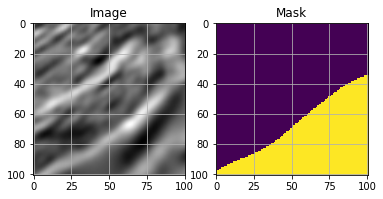

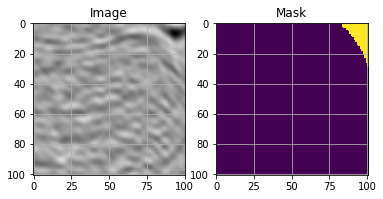

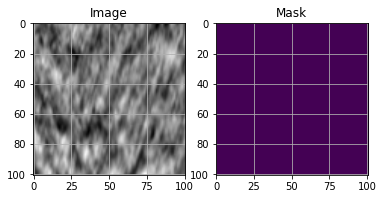

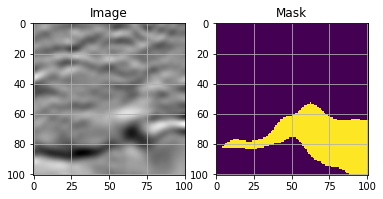

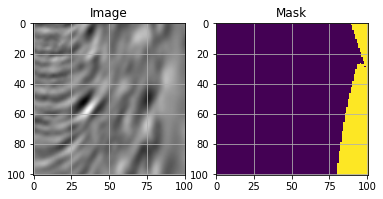

In [25]:
#Display five random images.
for i in range(5):
  train_image, train_mask = train_dataset[np.random.randint(0, len(train_dataset))]
  plotImageAndMask(train_image, train_mask)

###Ausgabe der Häufigkeitsverteilung der Tiefe

Rein informativ folgt eine grafische Darstellung einer Häufigkeitsverteilung der Aufnahmetiefe. Die Tiefe ist ein skalarer Wert zwischen 0 und 1000.

Das Histogramm zeigt, dass die Anzahl der Aufnahmen linar bis zur maximalen Aufnahmetiefe von ca. 550m steigt und bis zu einer Tiefe von ca. 850m wieder linear abfällt. Auffällig ist, dass ab ca. 850m die Anzahl der Aufnahmen sprunghaft auf ca. 100m abfällt.

Text(0.5, 1.0, 'Depth distribution')

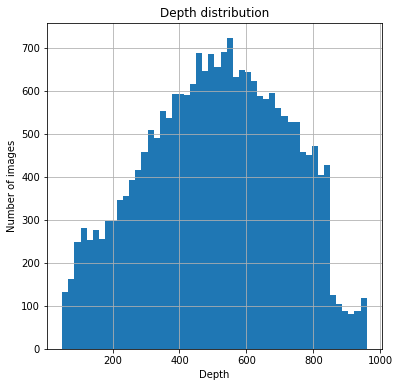

In [26]:
#plot the distribution of depths
plt.figure(figsize = (6, 6))
plt.hist(depth_csv['z'], bins = 50)
plt.xlabel("Depth")
plt.ylabel("Number of images")
plt.grid()
plt.title('Depth distribution')

###Ausgabe der Korrelation zwischen Tiefe und Salzgehalt

Zubnächst wird mit der vorher definierten Funktion rleToMask die lauflängenkodierten Bilddaten der maskierten Trainingsdaten dekodiert. Die dekodierten Bilddaten werden in einer neuer Spalte in train_csv ergänzt.

Anschließend wir der relative Salzgehalt eines Bildes mit der vorher definierten Funktion salt_proportion bestimmt.

In [0]:
train_csv['mask'] = train_csv['rle_mask'].apply(lambda x: rleToMask(x, 101, 101))
train_csv['salt_proportion'] = train_csv['mask'].apply(lambda x: salt_proportion(x))

Die Datei train_csv wird mit den Informationen der depth_csv ergänzt, um später einen einfacherern Zugriff auf die Daten zu erwirken.

In [28]:
train_depth_csv = train_csv.merge(depth_csv, how = 'left')
train_depth_csv.head(5)

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Im nachfolgenden Plot ist zu erkennen. dass in jeder Tiefe Bilder existieren, die kein Salz enthalten.

In einer Tiefe von 300m bis 800m sind die meisten Bilder mit einem Salzgehalt von 100% zu finden.

In einer Tiefe von 200m bis 800m sind scheinbar Bilder vorhanden, die einen Salzgehalt von mehr als 0% und weniger als 100% Salzgehalt nachweisen.



Text(0.5, 1.0, 'Proportion of salt and depth')

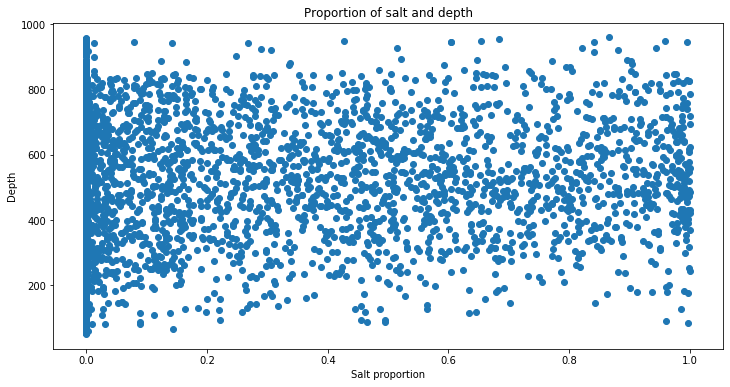

In [29]:
plt.figure(figsize = (12, 6))
plt.scatter(train_depth_csv['salt_proportion'], train_depth_csv['z'])
plt.xlabel("Salt proportion")
plt.ylabel("Depth")
plt.title('Proportion of salt and depth')

#II. Definition des U-Net-Modells

In [0]:
img_width = 128
img_height = 128
img_chan = 2 #number of channels: first is original and second cumsum(axis=0)
n_features = 1 #number of extra features, like depth

In [0]:
input_img = Input((img_height, img_width, img_chan), name='img')
input_features = Input((n_features, ), name='feat')

#Contracting path
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

#Join features information in the depthest layer
f_repeat = RepeatVector(8*8) (input_features)
f_conv = Reshape((8, 8, n_features)) (f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

#Expansive path
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]            

#III. Training des U-Net-Modells

##Vorbereitung

In [0]:
border = 5

In [0]:
train_ids = os.listdir(train_path + '/images')

# Get and resize train images and masks
X = np.zeros((len(train_ids), img_height, img_width, img_chan), dtype=np.float32)
y = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):    
    # Depth
    #X_feat[n] = depth_csv.loc[id_.replace('.png', ''), 'z']

    # Load X
    img = load_img(train_path + '/images/' + id_, color_mode = "grayscale")
    x_img = img_to_array(img)
    x_img = resize(x_img, (img_height, img_width, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(train_path + '/masks/' + id_, color_mode = "grayscale"))
    mask = resize(mask, (img_height, img_width, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('\nDone!')

Getting and resizing train images and masks ... 


100%|██████████| 4000/4000 [00:24<00:00, 160.90it/s]

Done!


In [0]:
X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

##Training

In [0]:
callbacks = [
    EarlyStopping(patience = 5, verbose = 1),
    ReduceLROnPlateau(patience = 3, verbose = 1),
    ModelCheckpoint('model.h5', verbose = 1, save_best_only = True, save_weights_only = True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))




Train on 3400 samples, validate on 600 samples
Epoch 1/50





3400/3400 [==============================] - 18s 5ms/step - loss: 0.5306 - val_loss: 0.5159

Epoch 00001: val_loss improved from inf to 0.51587, saving model to model.h5
Epoch 2/50
3400/3400 [==============================] - 4s 1ms/step - loss: 0.4592 - val_loss: 0.3820

Epoch 00002: val_loss improved from 0.51587 to 0.38204, saving model to model.h5
Epoch 3/50
3400/3400 [==============================] - 4s 1ms/step - loss: 0.3638 - val_loss: 0.3344

Epoch 00003: val_loss improved from 0.38204 to 0.33437, saving model to model.h5
Epoch 4/50
3400/3400 [==============================] - 4s 1ms/step - loss: 0.3130 - val_loss: 0.3113

Epoch 00004: val_loss improved from 0.33437 to 0.31132, saving model to model.h5
Epoch 5/50
3400/3400 [==============================] - 4s 1ms/step - loss: 0.2758 - val_loss: 0.3489

Epoch 00005: val_loss did not improve from 0.31132
Epoch 6/50
3400/3400 [==============================] - 4s

#IV. Evaluierung des U-Net-Modells

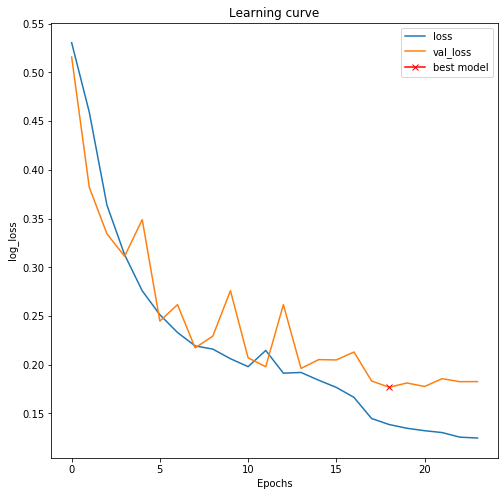

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
#Load best model
model.load_weights('model.h5')

In [0]:
#Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

ValueError: ignored

#V. Temp

In [31]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = os.listdir(path + '/images')
    X = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)

    if train:
        y = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')

    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_, color_mode = "grayscale"))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train_path, train=True)

  0%|          | 15/4000 [00:00<00:28, 138.05it/s]

Getting and resizing images ... 


100%|██████████| 4000/4000 [00:23<00:00, 172.27it/s]

Done!


In [0]:
# Split train/valid and test
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.10, random_state=1234)

In [0]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.222, random_state=2345)

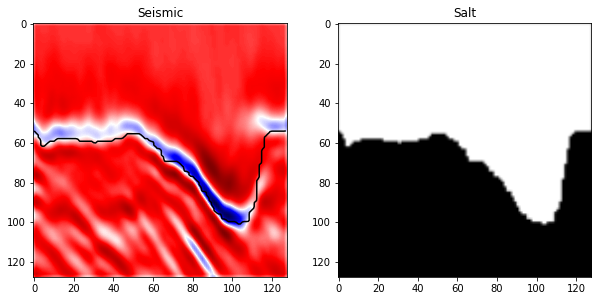

In [47]:
import random

# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [50]:
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.optimizers import Adam

input_img = Input((img_height, img_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [55]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 2800 samples, validate on 800 samples
Epoch 1/100
2800/2800 [==============================] - 26s 9ms/step - loss: 0.1731 - acc: 0.9245 - val_loss: 0.2675 - val_acc: 0.8937

Epoch 00001: val_loss did not improve from 0.21229
Epoch 2/100
2800/2800 [==============================] - 25s 9ms/step - loss: 0.1723 - acc: 0.9241 - val_loss: 0.2276 - val_acc: 0.9156

Epoch 00002: val_loss did not improve from 0.21229
Epoch 3/100
2800/2800 [==============================] - 25s 9ms/step - loss: 0.1587 - acc: 0.9290 - val_loss: 0.2266 - val_acc: 0.9066

Epoch 00003: val_loss did not improve from 0.21229
Epoch 4/100
2800/2800 [==============================] - 25s 9ms/step - loss: 0.1619 - acc: 0.9291 - val_loss: 0.2036 - val_acc: 0.9152

Epoch 00004: val_loss improved from 0.21229 to 0.20359, saving model to model-tgs-salt.h5
Epoch 5/100
2800/2800 [==============================] - 25s 9ms/step - loss: 0.1451 - acc: 0.9341 - val_loss: 0.1843 - val_acc: 0.9213

Epoch 00005: val_loss imp

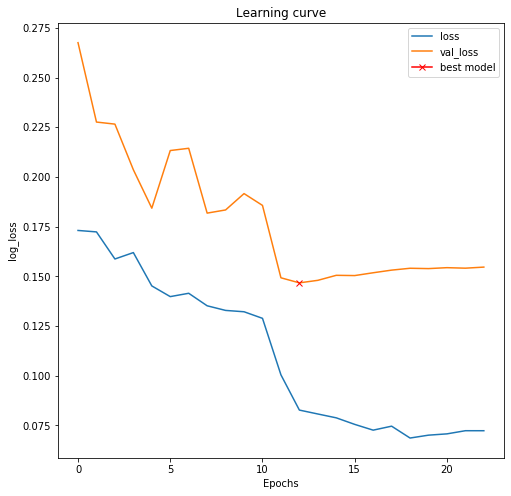

In [56]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
#Load best model
model.load_weights('model-tgs-salt.h5')

In [60]:
#Evaluate on validation set (this must be equals to the best log_loss)



#1. intersection of union erklären
#2. data augmentation



model.evaluate(X_test, y_test, verbose=1)

400/400 [==============================] - 1s 2ms/step


[0.1759270417690277, 0.922908935546875]

In [64]:
#Predict on test
preds_test = model.predict(X_test, verbose=1)
#preds_val = model.predict(X_valid, verbose=1)

#Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)

400/400 [==============================] - 1s 3ms/step


In [86]:
preds_test

array([[[[0.05347386],
         [0.04426441],
         [0.04337955],
         ...,
         [0.02236041],
         [0.05095467],
         [0.04047576]],

        [[0.04870021],
         [0.01690355],
         [0.01151776],
         ...,
         [0.00758865],
         [0.01516739],
         [0.02190018]],

        [[0.03513491],
         [0.01273453],
         [0.00736654],
         ...,
         [0.00620717],
         [0.00893041],
         [0.02316311]],

        ...,

        [[0.01449379],
         [0.00533471],
         [0.00254256],
         ...,
         [0.00355774],
         [0.007274  ],
         [0.01401973]],

        [[0.01864094],
         [0.01029465],
         [0.00518593],
         ...,
         [0.00807682],
         [0.01185113],
         [0.02851567]],

        [[0.03933543],
         [0.04646856],
         [0.02443561],
         ...,
         [0.03243721],
         [0.03301752],
         [0.03594589]]],


       [[[0.05644926],
         [0.05602366],
         [0.05

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))

    #Image 1
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    #Image 2
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    #Image 3
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    #Image 4
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

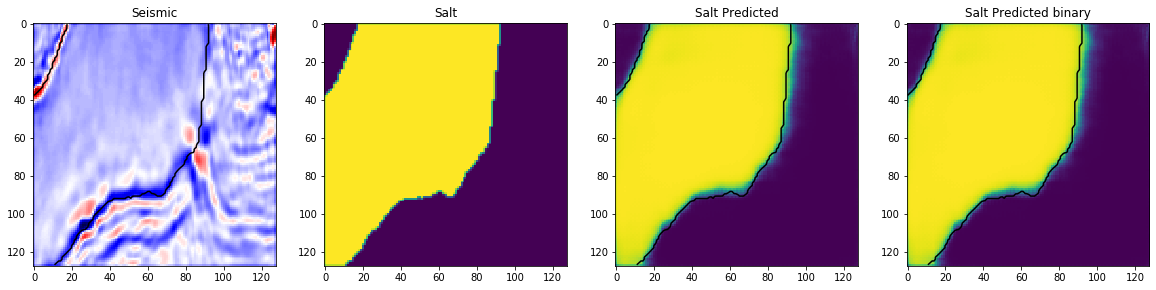

In [84]:
#Check if training data looks all right
plot_sample(X_test, y_test, preds_test, preds_test)

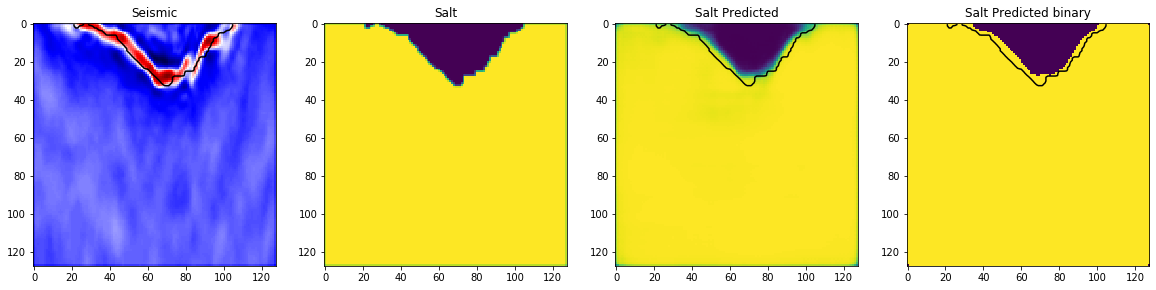

In [0]:
#Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=11)

In [0]:
!ls -l -h /content/salt_data

total 203M
-rw-r--r-- 1 root root 322K Nov 27 07:28 depths.csv
-rw-r--r-- 1 root root 264K Nov 27 07:28 sample_submission.csv
drwxr-xr-x 3 root root 4.0K Nov 27 07:28 test
-rw-r--r-- 1 root root 164M Nov 27 07:28 test.zip
drwxr-xr-x 4 root root 4.0K Nov 27 07:28 train
-rw-r--r-- 1 root root 922K Nov 27 07:28 train.csv
-rw-r--r-- 1 root root  38M Nov 27 07:28 train.zip
